# Are you Being Served? A Study on the Public Transport Availability in Pittsburgh 

<img src="images/pitts.jpg" width="500px">

## 1. Introduction

Public transportation is not just moving people from point A to point B. It is also a system that either expands or limits the opportunities available to the populace. Are communities in Pittsbugh being fairly served through public transportation? 

### Approach

We will investigate the degree which the public transport system in Pittsburgh meets the demand of the various communities. The US census data would be used to model the demographic and travel patterns of the communities. In particular, we intend to use economic characteristics like income, occupation, housing characteristics like size, density, vehicles owned and commuting characteristics like mode of transport and travel time. 

The Port Authority of Pittsburgh provides monthly data on the routes and schedules of the public transportation such as buses and light rail. We would use the data and measure the supply and quality of service of the transportation means. 

Merging both data sets, we would seek to establish a relation between the requirement and availability of public transport service of the various Pittsburgh communities (tracts). Also an outlier analysis would be done to examine if there are communities that are overserved or underserved. 

The data and results of our analysis would be presented on interactive maps, allowing better trend visualization and data exploration.

### Overview

The notebook is organized in the following sections:

1. Introduction
2. Data Sets Used
3. Data Processing and Feature Generation
4. Understanding Correlations in the Data
5. Rush Hour Demands Analysis
6. Outlier Tracts Analysis
7. Conclusion
8. References
9. Code blocks

### Software Stack Library 

[**QGIS**](http://www.qgis.org/en/site/)(Quantum GIS) is a powerful and free open source GIS tool. It is used in the project for some GIS processing algorithms and to generate the static visualization.

**Python Libraries**
Numpy GeoPandas, Pandas, RTrees and Folium for data processing and visualization.

**Folium** is a great *interactive* geospatial visualization python library. Folium builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the Leaflet.js library. The library has a number of built-in tilesets such as OpenStreetMap.

**Note:** The bulk of the python code is in the last section for better reability of the notebook. Please execute the code blocks in the last section first before running other section's code fragment. The code fragments intersperse throughout the section are for highlighting results or visualization.


## 2. Data Sets Used

### Port Authority Data 

1. http://www.portauthority.org/GeneralTransitFeed/
2. http://www.portauthority.org/GeneralTransitFeed/GIS/

The Pittsburgh Port Authority (PA) provides comprehensive data on the public transport network from the light rail to the buses and live tracking data can be obtained via their [TrueTime](http://truetime.portauthority.org/bustime/home.jsp) portal. For our analysis, we would be using the static data that is compiled monthly. Below is an overview of the routes (red) and stops (green) data we collected.

<img src="images/transport_overview.png" width="500px">

### US Census Relationship Data

1. http://pittsburghpa.gov/dcp/gis/gis-data-new
2. http://www.census.gov/geo/maps-data/data/relationship.html

Though the US Census provides a plethora of information, we will extract relevant demographics information from the *2014 US Census Data*, such as commute preferences based on income, population density, travel time and frequency for public transport use, etc. The data is presented at the state level and partitioned geographically into communities, which are called *tracts*. Only Allegheny county's  census data would be used (highlighted in red).
<img src="images/tract_overview.png" width="500px">

### Tract data as common reference

Before the various data processing can be done on these different data sets, they need to be associated using a common reference. However there is no common field between the transport and census datasets. Fortunately, the datasets are related geo-spatially and can be plotted on a common map. First, the transportation routes would be associated to the stops which they make. Next, the stops are associated to the tracts, which we already connected with the census data. This links both datasets together and the joined data is stored as a vector file.

<img src="images/tract_transport_overview.png" width="500px">

## 3. Data Processing and Feature Generation

### Processing Transport Data

The transport data sets are loaded and converted to Coordinate Reference System of WGS84. Even though the US census datasets and PAT datasets are in the NAD93 CRS, it is easier to use WGS84 as it is a commonly used coordinate system by other GIS tools and Folium.

In [6]:
# run the code in the Code Block section first!

# common reference vector file.
tract_gpd = gpd.GeoDataFrame.from_file("GIS/census_tract/census_tract.shp")

# PA transport stops and route data from September 2016
stops_gpd = gpd.GeoDataFrame.from_file("GIS/PAAC_Stops_1609_FinalPublic/PAAC_Stops_1609_FinalPublic.shp")
routes_gpd = gpd.GeoDataFrame.from_file("GIS/PAAC_Routes_1609_Final_Public/PAAC_Routes_1609_Final_Public.shp")

# converting of CRS
tract_gpd = tract_gpd.to_crs(epsg='4326')
stops_gpd = stops_gpd.to_crs(epsg='4326')
routes_gpd = routes_gpd.to_crs(epsg='4326')
tract_gpd.head()

,AFFGEOID,ALAND,AWATER,COUNTYFP,GEOID,LSAD,NAME,STATEFP,TRACTCE,geometry
0,1400000US42003050100,790374,0,003,42003050100,CT,501,42,050100,"POLYGON Z ((-79.982429 40.446493 0, -79.97555 ..."
1,1400000US42003080600,404921,0,003,42003080600,CT,806,42,080600,"POLYGON Z ((-79.943535 40.460022 0, -79.943218..."
2,1400000US42003090200,446354,0,003,42003090200,CT,902,42,090200,"POLYGON Z ((-79.96091 40.469796 0, -79.9588079..."
3,1400000US42003111400,327621,0,003,42003111400,CT,1114,42,111400,"POLYGON Z ((-79.936441 40.464676 0, -79.934617..."
4,1400000US42003140500,754718,0,003,42003140500,CT,1405,42,140500,"POLYGON Z ((-79.911418 40.454915 0, -79.909686..."


### Generating Features for the Quality of Public Transport

We would create 2 new features to measure the quality of the public transport:
1. Mean area coverage of each stop
2. Mean frequency of services at each stop

The area coverage of stop represents the area which that stop serves. We made the simplifying assumption that commuters would go to the nearest stop for transport, on average. This feature was created as we felt that the number or density of stops in a tract does not adequately capture the availablity of service. Ideally, stops should be dispersed throughout the tract such that the total distance to reach a stop by any commuter is minimized. To compute the coverage of a stop, we used a [Voronoi partition](https://en.wikipedia.org/wiki/Voronoi_diagram) of the stops. The cell enclosing the stop represents the area for which that stop is the nearest stop. The larger the mean area coverage of a tract, the poorer is the quality of service as the stop is serving a larger area, possibly more commuters. Thus we want the average stop to have a small area coverage. 

The vector::triangulation tool in QGIS is used compute the area coverage. Below is an example of the bus stops around Carnegie Mellon University, showing the area each bus stop serves.

<img src="images/nearest_stop.png" width="800px">
  

In [9]:
# nearest stop vector file, generated using QGIS
nearest_stops_gpd = gpd.GeoDataFrame.from_file('GIS/nearest_stops/nearest_stops.shp')
nearest_stops_gpd = nearest_stops_gpd.to_crs(epsg='4326')

PA routes have a score for frequency of service called "Avg_Wkdy_F". This takes into account the service on weekdays and it is normalized for the duration of each service as different services have different schedules. Also, weekend services are not examined. Below is a plot of the services and their frequencies. We observed that express and rapid routes have much higher scores.

,Avg_Wkdy_F,ROUTE,TypeServ
22,11222.0,P1,Rapid
102,10444.0,RED,Rapid
28,10356.0,BLSV,Rapid
62,8074.0,51,Key Corridor
27,7063.0,BLLB,Rapid


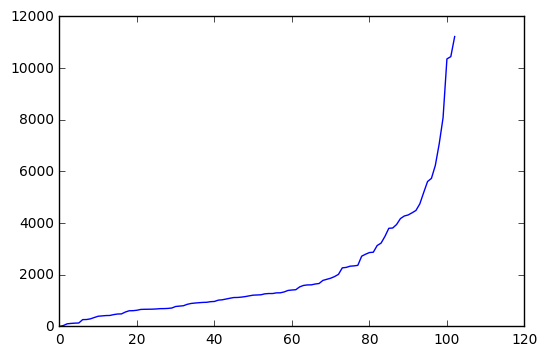

In [39]:
plt.plot(sorted(routes_gpd['Avg_Wkdy_F']));

# top 5 services in adjusted frequency
routes_gpd.sort_values(by=['Avg_Wkdy_F'], ascending=[False])[['Avg_Wkdy_F','ROUTE','TypeServ']].head() 

To merge the transport data with the tract data, we first associate the routes and coverage partition to the stops using the key "CleverID". Next we do a spatial join (using SJOIN) with the tracts using their respective geospatial "geometry" field. The field "AFFGEOID" is copied over as this would be the common key with the census data.

In [10]:
#function def in code blocks
transport_merge_pd = merge_transport_to_tract(tract_gpd, stops_gpd, nearest_stops_gpd, routes_gpd)
transport_merge_pd.head()

,GEOID,bus_mean_service,busstop_count,busstop_mean_coverage
0,42003050100,2864.183333,30.0,39195.666667
1,42003080600,2652.282353,17.0,29753.882353
2,42003090200,2308.818182,11.0,71906.363636
3,42003111400,3027.222222,9.0,33853.333333
4,42003140500,3274.200000,15.0,49114.266667


### Processing US Census Data

Demographics information is extracted from the US census data and merged with the transport data. Specifically we use the following fields: 
["BusTravelers", "Travelers", "ALAND", "Count", "MedianEarning", "BusTravelersMedianEarning", "MeanIncome" ]. 

In [13]:
# US Census data merged on transport data
census = pd.read_csv("Census Data/ACS_14_5YR_B08006_with_ann.csv")
population = pd.read_csv("Census Data/ACS_14_5YR_B01003_with_ann.csv")
earning = pd.read_csv("Census Data/ACS_14_5YR_B08121_with_ann.csv")
income = pd.read_csv("Census Data/ACS_14_5YR_S1902_with_ann.csv")
vehicles = pd.read_csv("Census Data/ACS_14_5YR_B08015_with_ann.csv")
census_data = merge_census_data(tract_gpd, transport_merge_pd, census, population, earning, income, vehicles)
# fields with missing data is assumed to be 0.0
census_data.head()

,busstop_count,bus_mean_service,busstop_mean_coverage,BusTravelers,Travelers,ALAND,Count,MedianEarning,BusTravelersMedianEarning,MeanIncome,TotalVehiclesUsed
GEOID,,,,,,,,,,,
42003050100,30.0,2864.183333,39195.666667,226.0,626.0,790374.0,1685.0,27500.0,14453.0,17554.0,290.0
42003080600,17.0,2652.282353,29753.882353,229.0,1415.0,404921.0,2078.0,31747.0,33583.0,36255.0,665.0
42003090200,11.0,2308.818182,71906.363636,315.0,1642.0,446354.0,2790.0,35667.0,35074.0,28667.0,840.0
42003111400,9.0,3027.222222,33853.333333,193.0,431.0,327621.0,1304.0,26250.0,24821.0,15535.0,185.0
42003140500,15.0,3274.200000,49114.266667,244.0,1039.0,754718.0,1783.0,39205.0,32375.0,35054.0,625.0


## 4. Understanding correlations in the data

### Pair plots of demographic and PA data

We would evaluate if there exists a relation between the demographic and geographic features of a tract with the transport services. The features used are population(feature name: count), number of bus travelers, income of people, and area of the tract along with the above computed metrics;  bus stop count, service score and mean coverage. A pair plot is generated to visually evaluate relationship between these attributes as well as to compute the Spearman correlation, which describes the monotonic relationship between 2 variables(need not be linear).

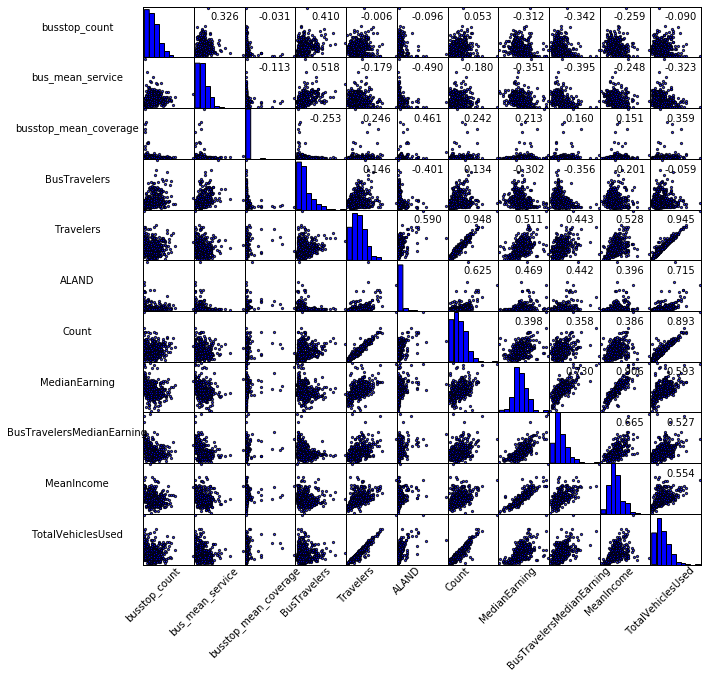

In [14]:
data = census_data.as_matrix() # each row of represents a variable
m,n = data.shape
sm = scatter_matrix(census_data, figsize=(10,10), alpha=0.8)

# plot visualization adjustments
for s in sm.reshape(-1):
    s.xaxis.label.set_rotation(45)
    s.yaxis.label.set_rotation(0)
    s.get_xaxis().set_label_coords(+0.2,0)
    s.get_yaxis().set_label_coords(-1.3,0.5)
    s.set_xticks(())
    s.set_yticks(())

#spearman correlation
corr = census_data.corr(method = 'spearman').as_matrix()
for i, j in zip(*plt.np.triu_indices_from(sm, k=1)):
    sm[i, j].annotate("%.3f" %corr[i,j], (0.6, 0.8), xycoords='axes fraction', ha='center', va='center')
    
plt.show()

Most of the correlation values we found are significant.

Evidently, features like population and number of travelers have a strong correlation. Tracts with higher median income tend to use more vehicles, as implied by a positive correlation between the same. People in such tracts prefer using private transport. 

Even though the bus stop count and number of bus travelers have a positive correlation (0.4), the correlation is not very strong implying that there are tracts with large populations where the number of bus stops are not adequate. This can be even verified in the scatter plot. Similarly a positive correlation exists between bus stop count and bus travelers, and service score and bus travelers. The correlation is not strong which again emphasizes that there are tracts with large number of bus travelers which are not being served very well and have inadequate bus stops.

We can also observe that there are certain tracts in the graph which have very poor coverage. Their corresponding service score and bus stop counts are also bad. These might be same or near by tracts which we will analyze later in outlier analysis.

In the plot for area vs coverage it can be noted that there are certain tracts with less area but still have poor coverage.

Though we could not establish very strong correlations between the features, we conjectured the existence of outliers and a recurring pattern among them which we will evaluate in the *Outlier Tracts Analysis section*

## Analysis of Rush Hour Demands

The bulk of the commuters travel during the rush hour to get to their workplace and the US census data track travel patterns with more granularity between 5:00 am to 10:00 am. To meet this demand, the Port Authority runs additional rapid services during the peak hour. We were interested to see if these rapid services meet the rush hours' demand. From the census data, we extract the public transport commuter numbers during the peak hours.

In [109]:
start_time_df = load_census_df('Census Data/ACS_14_5YR_B08011 - by start time/ACS_14_5YR_B08011_with_ann.csv')
travel_time_df = load_census_df('Census Data/ACS_14_5YR_B08012 - by travel time/ACS_14_5YR_B08012_with_ann.csv')
transport_mode_df = load_census_df('Census Data/ACS_14_5YR_B08006 - by mode of commute/ACS_14_5YR_B08006_with_ann.csv')
transport_mode_sub_df = transport_mode_df[['Id2','Estimate; Total:', 
                                           'Estimate; Total: - Public transportation (excluding taxicab):',
                                           'Estimate; Total: - Worked at home']].copy(deep=True)
transport_mode_sub_df['public transport ratio'] = transport_mode_sub_df['Estimate; Total:'] - transport_mode_sub_df['Estimate; Total: - Worked at home']
transport_mode_sub_df['public transport ratio'] = transport_mode_sub_df['Estimate; Total: - Public transportation (excluding taxicab):'] / transport_mode_sub_df['public transport ratio']

To form the aggregated demand during the peak hour for each tract, we first find the expected demand based on the entire Allgenhy county. This expected demand would then be used to take a weighted sum of the peak hour demands for each tract. The motivation is to reduce the effect of any tract specific demand pattern. 

In [112]:
start_sub_df = start_time_df[start_time_df.columns[[1,3,7,9,11,13,15,17,19,21,23]]].copy(deep=True)
peak_hr_weights = []
for i in xrange(2,11):
    peak_hr_weights.append(np.sum(start_sub_df.ix[:,i].values))
peak_hr_weights = np.array(peak_hr_weights).astype(float)
peak_hr_weights /= np.sum(peak_hr_weights)
start_sub_df = start_sub_df.sort_values(start_sub_df.columns[[7,8,9,10]].tolist(), ascending=False)
start_sub_df = start_sub_df.rename(columns={'Id2': 'GEOID'})
start_sub_df.head()

,GEOID,Estimate; Total:,Estimate; Total: - 5:00 a.m. to 5:29 a.m.,Estimate; Total: - 5:30 a.m. to 5:59 a.m.,Estimate; Total: - 6:00 a.m. to 6:29 a.m.,Estimate; Total: - 6:30 a.m. to 6:59 a.m.,Estimate; Total: - 7:00 a.m. to 7:29 a.m.,Estimate; Total: - 7:30 a.m. to 7:59 a.m.,Estimate; Total: - 8:00 a.m. to 8:29 a.m.,Estimate; Total: - 8:30 a.m. to 8:59 a.m.,Estimate; Total: - 9:00 a.m. to 9:59 a.m.
122,42003409000,5318,173,221,445,537,879,887,639,322,283
192,42003453004,4106,123,172,171,351,728,678,595,276,310
127,42003413100,3460,61,64,267,347,624,660,465,237,165
125,42003412001,3685,63,68,374,369,577,642,577,425,271
195,42003456003,3130,122,163,320,345,357,599,418,221,165


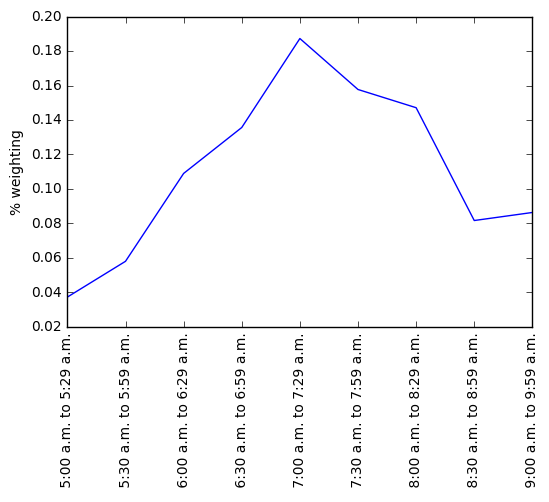

In [346]:
plt.plot(peak_hr_weights);
labels =  start_sub_df.columns[2:]
labels = [l.replace('Estimate; Total: -','') for l in labels]
plt.ylabel('% weighting')
plt.xticks(range(len(peak_hr_weights)), labels, rotation=90);

We can see the demand peaks between *7:00am and 7:30am*

Now we compute the weighted demand for each tract

In [142]:
transport_mode_sub_df = transport_mode_sub_df.rename(columns={'Id2': 'GEOID'})
peak_hr_demand = np.zeros(len(start_sub_df))
total_peak_hr_demand = np.zeros(len(start_sub_df))
for i in xrange(2,11):
    peak_hr_demand += start_sub_df.ix[:,i].values*peak_hr_weights[i-2]
    total_peak_hr_demand += start_sub_df.ix[:,i].values

peak_demand_df = start_sub_df[['GEOID']].copy(deep=True)
peak_demand_df['weighted demand'] = pd.Series(peak_hr_demand)
peak_demand_df['total demand'] = pd.Series(total_peak_hr_demand)
peak_demand_df = peak_demand_df.merge(transport_mode_sub_df[['GEOID','public transport ratio' ]], on='GEOID')
peak_demand_df['weighted public transport demand'] = peak_demand_df['weighted demand']*peak_demand_df['public transport ratio']
peak_demand_df['total public transport demand'] = peak_demand_df['total demand']*peak_demand_df['public transport ratio']
peak_demand_df.fillna(0,inplace=True)
peak_demand_gpd = gpd.GeoDataFrame(peak_demand_df)
peak_demand_gpd = peak_demand_gpd.merge(tract_gpd[['GEOID','geometry']], on='GEOID')

Below, we plot the tract demand with respect to the Rapid bus services. Note that not all tracts have signifcant peak hour demands. The rapid bus service operates approximately through the center of the tracts which have significant peak hour demands. We do note that there is a pocket of demand to the north of Downtown that is not covered by the Rapid services. We hypothesize that the commuters are sufficiently close to the Downtown offices that it is covered by the express buses. 

However, travellers would still need another means of transportation to get to the rapid bus services as they do not travel through the normal roads, but use dedicated bus lanes.  

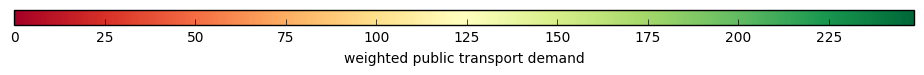

In [359]:
express_routes_gpd = routes_gpd[(routes_gpd['TypeServ']=='Rapid') & (routes_gpd['Mode']!='Incline')]
express_routes_json = express_routes_gpd['geometry'].to_json()
peak_map, viz_gpd = plot_on_map(peak_demand_gpd, 'weighted public transport demand', 0.1)
fig = plt.figure(figsize=(10, 1))
ax1 = fig.add_axes([0.05, 0.2, 0.9, 0.15])
cmap = matplotlib.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=np.min(peak_demand_gpd['weighted public transport demand']), 
                                   vmax=np.max(peak_demand_gpd['weighted public transport demand']))
cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('weighted public transport demand')
folium.GeoJson(express_routes_json, style_function=lambda feature:{'color':'#00ffaa'}).add_to(peak_map)
peak_map
#Rapid Bus service shown as green trails

## 6. Outlier Tracts Analysis

The outlier analysis is performed on the combined data on the attributes - mean coverage, quality of service, population, number of bus travellers, number of bus stops, area, and median income of the entire population and bus traveler population. From the pair plots, we know most of the feature interactions are nonlinear, hence a Gaussian Mixture Model was used to model the distribution of the features. 

The number of mixtures was determined empirically using an elbow plot which is shown below:

![Sum of Squared Error vs k](OutlierAnalysis/SSEvsK_elbow.png)

In [328]:
census_data.describe()

,busstop_count,bus_mean_service,busstop_mean_coverage,BusTravelers,Travelers,ALAND,Count,MedianEarning,BusTravelersMedianEarning,MeanIncome
count,355.000000,355.000000,3.550000e+02,355.000000,355.000000,3.550000e+02,355.000000,355.000000,355.000000,355.000000
mean,18.757746,1634.907035,9.141157e+05,135.828169,1500.197183,4.019502e+06,3105.600000,35641.002817,35494.709859,29648.211268
std,14.474717,1289.189102,3.868340e+06,107.176059,823.961926,7.555866e+06,1554.618444,11328.307236,20860.458230,11810.451416
min,0.000000,0.000000,0.000000e+00,9.000000,144.000000,1.836440e+05,578.000000,3313.000000,2500.000000,2839.000000
25%,8.000000,858.921053,4.852257e+04,56.500000,878.500000,8.428040e+05,1871.500000,28577.500000,22040.500000,21772.500000
50%,17.000000,1300.890789,1.077400e+05,109.000000,1410.000000,1.599938e+06,2801.000000,34504.000000,30750.000000,28116.000000
75%,26.000000,2319.340125,3.035058e+05,172.500000,1979.000000,4.021044e+06,4126.000000,41631.500000,44198.000000,35392.500000
max,106.000000,10444.000000,4.202365e+07,748.000000,5772.000000,8.387325e+07,11975.000000,77708.000000,153750.000000,91741.000000


To calculate the outliers from the final probablities we obtained top 35 (~10% of the data) tracts with the lowest sum of products of probability of belonging to a cluster and the probability of that cluster. We repeated this step 10 times and then looked at top 15 tracts which appeared maximum number of times in all the different runs. We looked at the attributes manually to understand why these tracts were outliers and what insights we can get about the PA services from it.

In [335]:
#GEOIDs of outliers obtained from analysis
outliers_rowid = [185,354,129,304,49,196,254,256,342,221,16,152,153,38,170,178,55,183,226,352,101,238,239]
census_data.iloc[outliers_rowid]

,busstop_count,bus_mean_service,busstop_mean_coverage,BusTravelers,Travelers,ALAND,Count,MedianEarning,BusTravelersMedianEarning,MeanIncome
GEOID,,,,,,,,,,
42003474201,1.0,1825.000000,4.202365e+07,25.0,1064.0,3302634.0,2522.0,71389.0,75313.0,52574.0
42003452000,5.0,1071.800000,5.022205e+06,50.0,2598.0,83873250.0,5199.0,45625.0,90893.0,31621.0
42003451105,1.0,906.000000,2.947464e+07,43.0,2718.0,9558163.0,4586.0,35860.0,40673.0,32476.0
42003407001,0.0,0.000000,0.000000e+00,31.0,2584.0,48560312.0,4978.0,35988.0,54766.0,33076.0
42003413201,4.0,1183.500000,3.122329e+07,54.0,1925.0,3779913.0,3697.0,42609.0,46250.0,35562.0
42003496102,0.0,0.000000,0.000000e+00,33.0,2031.0,32772303.0,4444.0,38703.0,79125.0,29440.0
42003406000,0.0,0.000000,0.000000e+00,14.0,1115.0,33530710.0,2354.0,37883.0,60625.0,29767.0
42003413100,1.0,1214.000000,2.462091e+07,26.0,3668.0,15950132.0,7294.0,61793.0,97321.0,49950.0
42003473500,22.0,557.000000,2.654670e+05,29.0,1805.0,2382453.0,3934.0,74639.0,95250.0,51919.0


In [360]:
tract_gpd.head()

,AFFGEOID,ALAND,AWATER,COUNTYFP,GEOID,LSAD,NAME,STATEFP,TRACTCE,geometry
0,1400000US42003050100,790374.0,0.0,003,42003050100,CT,501,42,050100,"POLYGON Z ((-79.982429 40.446493 0, -79.97555 ..."
1,1400000US42003080600,404921.0,0.0,003,42003080600,CT,806,42,080600,"POLYGON Z ((-79.943535 40.460022 0, -79.943218..."
2,1400000US42003090200,446354.0,0.0,003,42003090200,CT,902,42,090200,"POLYGON Z ((-79.96091 40.469796 0, -79.9588079..."
3,1400000US42003111400,327621.0,0.0,003,42003111400,CT,1114,42,111400,"POLYGON Z ((-79.936441 40.464676 0, -79.934617..."
4,1400000US42003140500,754718.0,0.0,003,42003140500,CT,1405,42,140500,"POLYGON Z ((-79.911418 40.454915 0, -79.909686..."


In [402]:
outlier_gpd = tract_gpd[['GEOID', 'geometry']].copy(deep=True)
outlier_geoid = census_data.index.values[outliers_rowid]
outlier_gpd.set_index(keys='GEOID',inplace=True)
outlier_gpd['is outlier'] = pd.Series(np.zeros(len(tract_gpd), dtype=int),  index=outlier_gpd.index)
outlier_gpd['is outlier'].loc[outlier_geoid] = 1.0
outlier_gpd.reset_index(inplace=True)
outlier_map , _ = plot_on_map(outlier_gpd, 'is outlier', 0.5)
outlier_map 
#outlier tracts in green

We found that the outliers can be broken down into a few general catogeries.

### High income tracts with low demand and poor service and coverage
<img src="images/outlier_42003474201.png" width="800px">

These tracts such as the one in Mt Lebanon have much higher than average income. There are very little bus stops and routes that run through them. Often, they are found on terrains which makes it hard for construction of bus stops. We hypothesis that the populace commute using private transportation means.


### Well serviced tracts with high coverage but very low income and high demand
<img src="images/outlier_42003982200.png" width="800px">

Tract 42003982200 is a particularly interesting tract. It has extremely low bus traveller income of **$2500.0 per annum** which is the lowest of all the tracts but it is extremely well serviced . Turns out that this tract is where the University of Pittsburgh and its campus housing is located. Thus, it made sense that college students have virtually no income but take the bus frequently with their student transportation pass.

### Well serviced tracts with only 1 bus stop
<img src="images/outlier_42003484000.png" width="800px">
There are some tracts with only 1 bus stop but with high bus frequencies and high demands. These are tracts with a express service, such as 28X, that loops at that stop, contributing to the high frequencies.  

### Tracts with demand but no service
<img src="images/outlier_4200347001.png" width="800px">
Such tracts occurs at the fringe of Allegheny county. While no service runs through them, there are demands for buses. We hypothesize that the residents travel to adjencent tracts for transportation.


## Conclusion

From our outlier, correlation and peak hour analysis we can posit that Pittsburgh Port Authority service is doing an overall good job. They have good service and coverage in areas of low income and high demand (eg: tracts with dominant student population). On average, bus stop count is higher and coverage is better in larger (area wise) tracts which are inside the city. For tracts which lie on the outskirts, the coverage and service are poor. 

An important question which this data is unable to answer is why tracts (mostly rich ones) with poor service have low demand. The very reason for low demand maybe how people have established alternate means of travel given the service was poor. Another reason can be that only people who could afford other means of transport decided to stay in these tracts. We observed that; in tracts with higher incomes than usual, a large fraction of people used private means for transportation. We need to do a complete temporal analysis to comment on these trends.

We also observed that certain tracts have less bus stops or clustered bus stops. The reason for this anomaly can be attributed to the constraints imposed by location of highway and geographical features of the tract. 
In addition, the express service analysis revealed that there was a significant overlap in the time intervals of peak service and peak demand. This corroborates our initial claim.

In conclusion, the Port Authority of Pittsburgh is doing a *good job* at fairly serving the community!

<img src="images/truetime.png" width="500px">

## Code Blocks

### Data processing

In [2]:
# RUN ME FIRST!

# data processing libraries
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import shapely.wkt

#analysis 
import numpy as np
import scipy as sp
from numpy import corrcoef, sum, log, arange
from numpy.random import rand
from scipy import stats

#visualization
import folium
import matplotlib.pyplot as plt
import matplotlib 
from pandas.tools.plotting import scatter_matrix
from pylab import pcolor, show, colorbar, xticks, yticks
from IPython.display import HTML, Image
import sys
%matplotlib inline

In [3]:
def merge_transport_to_tract(tract_gpd, stops_gpd, nearest_stops_gpd, routes_gpd):
    
    bus_freq_map = {}
    for _,row in routes_gpd.iterrows():
        bus_freq_map[row['ROUTE']] = np.float(row['Avg_Wkdy_F'])
    
    stops_sub_gpd = stops_gpd[['CleverID','geometry','Routes_160']].copy(deep=True)
    out_gpd = stops_sub_gpd.merge(nearest_stops_gpd[['CleverID','area']], on='CleverID', how='left')
    
    service = np.zeros(len(out_gpd))
    for i, row in out_gpd.iterrows():
        per_bus_str = [s.strip() for s in row['Routes_160'].split(',')]
        per_bus = []
        for pid in per_bus_str:
            if pid in bus_freq_map:
                per_bus.append(bus_freq_map[pid])
            if not pid in bus_freq_map and pid[1:] in bus_freq_map:
                per_bus.append(bus_freq_map[pid[1:]])
        if len(per_bus) != 0: 
            service[i] = np.mean(per_bus)
    out_gpd['service'] = pd.Series(service)

    stops_in_tract = sjoin(out_gpd, tract_gpd, how='left',op='within')
    grouped_stops = stops_in_tract.groupby('index_right')

    N = len(tract_gpd)
    busstop_count = np.zeros(N)
    bus_mean_service = np.zeros(N)
    bus_mean_coverage = np.zeros(N)
    geoid = ['']*N
    

    for name, group in grouped_stops:
        tract_id = int(name)
        busstop_count[tract_id] = len(group)
        bus_mean_service[tract_id] = np.mean(group['service'])
        bus_mean_coverage[tract_id] = np.mean(group['area'])
        geoid[tract_id] = group['GEOID'].iloc[0]
        
    merge_tract = pd.DataFrame(data = {'GEOID':geoid,'busstop_count':busstop_count,
                                      'bus_mean_service':bus_mean_service , 'busstop_mean_coverage':bus_mean_coverage})
    
    return merge_tract

In [12]:
def merge_census_data(tract, transport,  census, population, earning, income, vehicles):
 
    census = census.drop(census.index[[0]])
    population = population.drop(population.index[[0]])
    earning = earning.drop(earning.index[[0]])
    income = income.drop(income.index[[0]])
    vehicles = vehicles.drop(vehicles.index[[0]])
    
    transport = transport.rename(columns={'GEOID': 'GEO.id2'})
    tract = tract.rename(columns={'GEOID': 'GEO.id2'})
    
    census["HD01_VD10"] = census["HD01_VD10"].astype(float)
    census["HD01_VD01"] = census["HD01_VD01"].astype(float)
    population["HD01_VD01"] = population["HD01_VD01"].astype(float)
    
    population = population.rename(columns={'HD01_VD01': 'Count'})
    census = census.rename(columns={'HD01_VD10': 'BusTravelers', 'HD01_VD01': 'Travelers'})
    earning = earning.rename(columns={'HD01_VD02': 'MedianEarning', 'HD01_VD05': 'BusTravelersMedianEarning'})
    income = income.rename(columns={'HC02_EST_VC20': 'MeanIncome'})
    vehicles = vehicles.rename(columns={'HD01_VD01': 'TotalVehiclesUsed'})
    
    merged = tract
    merged = merged.merge(census, on=["GEO.id2"], how="inner")
    merged = merged.merge(population, on=["GEO.id2"], how="inner")
    merged = merged.merge(earning, on=["GEO.id2"], how="inner")
    merged = merged.merge(income, on=["GEO.id2"], how="inner")
    merged = merged.merge(transport, on=["GEO.id2"], how="outer")
    merged = merged.merge(vehicles, on=["GEO.id2"], how="inner")
    
    #specific features to copy
    columns = ["GEO.id2","busstop_count", "bus_mean_service", "busstop_mean_coverage", 
               "BusTravelers", "Travelers", "ALAND", "Count", 
               "MedianEarning","BusTravelersMedianEarning", "MeanIncome", "TotalVehiclesUsed"]
    result = merged[columns].copy()
    result["ALAND"] = result["ALAND"].astype(float)
    result["Count"] = result["Count"]
    result["BusTravelers"] = result["BusTravelers"]
    
    result = result.replace('-', np.nan)
    result = result.replace('2,500-', 2500)
    result[["busstop_count", "bus_mean_service", "busstop_mean_coverage"]] = result[["busstop_count", "bus_mean_service", "busstop_mean_coverage"]].fillna(0.0)
    result = result.dropna()
    result["MedianEarning"] = result["MedianEarning"].astype(float)
    result["BusTravelersMedianEarning"] = result["BusTravelersMedianEarning"].astype(float)
    result["MeanIncome"] = result["MeanIncome"].astype(float)
    result["TotalVehiclesUsed"] = result["TotalVehiclesUsed"].astype(float)
    
    result = result.rename(columns={'GEO.id2':'GEOID'})
    result = result.set_index(['GEOID'], drop=True)
    return result

In [5]:
def load_census_df(filename):
    df = pd.read_csv(filename)
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace=True)
    for i in xrange(3,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].apply(np.int)
    
    return df


### Visualization

In [119]:
def convert_to_hex(rgba_color) :
    red = str(hex(int(rgba_color[0]*255)))[2:]
    green = str(hex(int(rgba_color[1]*255)))[2:]
    blue = str(hex(int(rgba_color[2]*255)))[2:]

    if blue=='0':
        blue = '00'
    if red=='0':
        red = '00'
    if green=='0':
        green='00'

    return '#'+ red + green + blue

In [401]:
def plot_on_map(gpd, value,value_alpha=0.0):
    viz = gpd[['geometry',value]].copy(deep=True)
    norm = plt.Normalize()
    norm_value = norm(viz[value]) 
    colors = plt.cm.RdYlGn(norm_value)
    colors = [convert_to_hex(c) for c in colors]
    viz['color'] = pd.Series(colors)
    alpha = 0.7*np.ones(len(viz))
    alpha[norm_value<value_alpha] = 0
    viz['alpha'] = pd.Series(alpha)
    
    viz_json = viz.to_json()
    viz_map = folium.Map(location=[40.4, -79.9],width=800, height=800, zoom_start=10, tiles='Stamen Toner')
    folium.GeoJson(viz_json,
    style_function=lambda feature: {
        'fillColor': feature['properties']['color'],
        'weight' : 1,
        'fillOpacity' : feature['properties']['alpha']
        }).add_to(viz_map)
    return viz_map, viz